In [2]:
import numpy as np
import glob
import os
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import correlate
#import stagnation.variables as va
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from natsort import natsorted, ns
import scipy.fft as fft

In [3]:
def gaussian(x, sig): #fonction de Gauss utlisé pour la normalisation et le calcul des poids de chaque points
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-1/2*(x/sig)**2)

In [4]:
def expo_decr(x,a,b,cte):
    return np.exp((-1/a)*x+b)+cte

In [5]:
L = 120 #box size
dx = 120/2**9 #minimum grid size
print(dx)
folderfig='/home/turbots/Documents/figure/'
eps = 7.8 #mean dissipation without the bubble
rho  = 1 #fluid density (taken as reference)
sig=dx/2

0.234375


In [6]:
folds = glob.glob('Re*') # we pick up all the filme that start with Re and put them in folds
print(len(folds))

0


In [8]:
datafolder = '/media/turbots/DATA1/Turdiphase/dissipationbubbles'
glob.glob(datafolder)

['/media/turbots/DATA1/Turdiphase/dissipationbubbles']

In [83]:

folds0 = 'Re55t140-l9-16-2540-2-dump_63405'
filesdissint = glob.glob(folds0+ '/localstats_[!f]*')
filesdissext = glob.glob(folds0 + '/localstats_fluid*')
filesinterf = glob.glob(folds0 + '/inter*.dat')
        
    

import warnings

with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
    warnings.simplefilter("ignore") 
#     dataint = np.zeros([0, 7], dtype=float)
#     dataext = np.zeros([0, 6], dtype=float)
    interf = np.zeros([0, 10], dtype=float)
    bubble = np.zeros([0, 12], dtype=float)
    stat = np.zeros([0, 8], dtype=float)
    vit_in = np.zeros([0,17], dtype=float)
    vit_interf = np.zeros([0,17], dtype=float)
    vit_out = np.zeros([0,16], dtype=float)
        


#     for file in filesdissint:
#         try:
#             datatemp = np.loadtxt(file, skiprows=2)
#         except:
#             datatemp = np.loadtxt(file, skiprows=1)
#         if datatemp.shape !=(0,):
#             dataint = np.vstack((dataint, datatemp))

    for file in filesinterf:
        datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            interf = np.vstack((interf, datatemp))

#     for file in filesdissext:
#         try:
#             datatemp = np.loadtxt(file, skiprows=1)
#         except:
#             datatemp = np.loadtxt(file, skiprows=0)
#         if datatemp.shape !=(0,):
#             dataext = np.vstack((dataext, datatemp))

try:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=0)
if datatemp.shape !=(0,):
    bubble = np.vstack((bubble,datatemp))
    
    
try:
    datatemp = np.loadtxt(folds0 +'/stats.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/stats.dat', skiprows=0)
if datatemp.shape !=(0,):
    stat = np.vstack((stat,datatemp))
    
datatemp=np.loadtxt(folds0 + '/vitessein_0.dat',skiprows=1)
if datatemp.shape !=(0,):
        vit_in = np.vstack((vit_in,datatemp))

datatemp=np.loadtxt(folds0 + '/vitesseinterf_0.dat',skiprows=1)
if datatemp.shape !=(0,):
        vit_interf = np.vstack((vit_interf,datatemp))

datatemp=np.loadtxt(folds0 + '/vitesseout_0.dat',skiprows=1)
if datatemp.shape !=(0,):
        vit_out = np.vstack((vit_out,datatemp))


In [84]:
R0= float(folds0.split('-')[2])

In [85]:
mask_vit_in=(vit_in[:,0]<600)
mask_vit_interf=(vit_interf[:,0]<600)

print(30*dx)
for bulle in bubble:
    if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
        j=bulle[2]
        mask_vit_in=np.logical_and(mask_vit_in,vit_in[:,0][:]!=j)
        mask_vit_interf=np.logical_and(mask_vit_interf,vit_interf[:,0][:]!=j)

7.03125


In [88]:
pc = np.median(vit_in[:, 1:4][mask_vit_in], axis=0)# approximate position center
print(pc)
interf[:, 1:4] = np.mod(interf[:, 1:4] - pc + L/2, L) - L/2 #shift interface position
vit_in[:, 1:4] = np.mod(vit_in[:, 1:4] - pc + L/2, L) - L/2 #shift data position
vit_interf[:, 1:4] = np.mod(vit_interf[:, 1:4] - pc + L/2, L) - L/2 #shift data position
vit_out[:, 0:3] = np.mod(vit_out[:, 0:3] - pc + L/2, L) - L/2 #shift data position
pc = np.mean(vit_in[:, 1:4][mask_vit_in], axis=0)# approximate position center
print(pc)


[0.    1.875 0.   ]
[-0.49951708  0.3856903   0.96808298]


In [89]:
# on masque les points extérieures de la bulle qui sont trop éloigné du centre de la bulle pour réduire le temps 
# de calcul et car on ne s'intéresse qu'a ce qu'il se passe proche de la bulle

mask_vit_out=((vit_out[:,0]-pc[0])**2+(vit_out[:,1]-pc[1])**2+(vit_out[:,2]-pc[2])**2<(36*R0**2)) #6*R0

In [90]:
z = np.mean(vit_in[:, 3][mask_vit_in])
dz=0.5
y=np.mean(vit_in[:, 2][mask_vit_in])
dy=0.5

indicez4= np.logical_and(vit_in[:, 3]>z-dz, vit_in[:, 3]<z+dz )
indicey4= np.logical_and(vit_in[:, 2]>y-dy, vit_in[:, 2]<y+dy )
mask_vit_in_1d=np.logical_and(indicey4,indicez4)
mask_vit_in_2d=np.logical_and(indicez4,mask_vit_in) #masque 2d pour le champ de données intérieures
# mask_vit_in_1d=np.logical_and(mask_vit_in_1d,mask_vit_in) #masque 1d pour le champ de données intérieures

indicez5= np.logical_and(vit_out[:, 2]>z-dz, vit_out[:, 2]<z+dz )
indicey5= np.logical_and(vit_out[:, 1]>y-dy, vit_out[:, 1]<y+dy )
mask_vit_out_2d=np.logical_and(mask_vit_out,indicez5)#masque 2d pour le champ de données extérieures
mask_vit_out_1d=np.logical_and(indicey5,indicez5)#masque 1d pour le champ de données extérieures
mask_vit_out_1d=np.logical_and(mask_vit_out,mask_vit_out_1d)


In [91]:
voronoi_kdtree = cKDTree(interf[:, 1:4]) #fonction qui trace un diagramme de Voronoi. 
#Ce diagrame permet de crée des régions où sont regorupés tout les points les points proches 
#d'un point de l'interface. Ça permet de calculer la distance des points à l'interface

In [92]:
test_point_dist_vit_out, test_point_regions_vit_out = voronoi_kdtree.query(vit_out[:, 0:3][mask_vit_out])
test_point_dist_vit_in, test_point_regions_vit_in = voronoi_kdtree.query(vit_in[mask_vit_in][:, 1:4])

In [101]:
print(test_point_regions_vit_out.shape,vit_out.shape)

(1690470,) (1693085, 16)


In [93]:
def calculate_normale(points,interf_points,region_index):
    
    normale=np.zeros([len(points),3])
    
    normale[:,:] = points[:,:] - interf_points[:,:][region_index]
    norm = np.sqrt(np.sum(normale[:,:]**2 , axis=1))
    normale /= norm[:,np.newaxis]
    
    return normale
    

In [94]:
def calculate_orthogonal_vectors(v): #calculer les deux vecteurs orthonormaux à un vecteur v
    
    
    # Générer un vecteur aléatoire de même dimension que v
    random_vector = np.random.randn(len(v))
    
    # Calculer le produit vectoriel entre v et le vecteur aléatoire
    cross_product = np.cross(v, random_vector)
    
    # Calculer le produit vectoriel entre v et le produit vectoriel précédent
    orthogonal_vector = np.cross(v, cross_product)
    
    # Normaliser les vecteurs
    cross_product_normalized = cross_product / np.linalg.norm(cross_product)
    orthogonal_vector_normalized = orthogonal_vector / np.linalg.norm(orthogonal_vector)
    
    return cross_product_normalized, orthogonal_vector_normalized

In [95]:
# normale = calculate_normale(vit_in[mask_vit_in][:,1:4],interf[:,1:4],test_point_regions_vit_in)
# print(normale[30:])

In [96]:
def calculate_vit_in(vit_in,region_index,interface): # calcul de la vitesse normale et des vitesses tangentielles pour 
#un array de vitesse en cartésien à l'interieur de la bulle + gradient normal et tangentielles

    normale = interface[region_index][:,7:10]
    norm=np.sqrt(np.sum(normale[:,:]**2,axis=1))
    normale[:,:] /= norm[:,np.newaxis]
    tangente1, tangente2 = np.zeros([len(normale),3]), np.zeros([len(normale),3])
    i=0
    for v in normale:
        tangente1[i,:], tangente2[i,:] = calculate_orthogonal_vectors(v)
        i+=1

    scal=np.zeros(len(vit_in))
    scal2=np.zeros(len(vit_in))
    scal3=np.zeros(len(vit_in))
    v_norm_in= np.zeros([len(vit_in),9])
    v_tang1_in= np.zeros([len(vit_in),9])
    v_tang2_in= np.zeros([len(vit_in),9])

    # normale=interf[region_index][:,7:10]

    scal[:]=np.sum(normale[:,0:]*vit_in[:,4:7],axis=1) #produit scalaire entre la normale et la vitesse
    scal2[:]=np.sum(tangente1[region_index][:,0:]*vit_in[:,4:7],axis=1)
    scal3[:]=np.sum(tangente2[region_index][:,0:]*vit_in[:,4:7],axis=1)


    #on recopie les coordonées du point
    v_norm_in[:,0:4]=vit_in[:,0:4]
    v_tang1_in[:,0:4]=vit_in[:,0:4]
    v_tang2_in[:,0:4]=vit_in[:,0:4]
    #calcul de vn
    v_norm_in[:,4]=scal[:]*normale[:,0] # vn = (v,normale)*normale
    v_norm_in[:,5]=scal[:]*normale[:,1]
    v_norm_in[:,6]=scal[:]*normale[:,2]
    #calcul de vt1
    # v_tang_in[:, 4:7] = vit_in[:, 4:7] - v_norm_in[:, 4:7] # vt = v - vn 
    v_tang1_in[:,4]=scal2[:]*tangente1[region_index][:,0]
    v_tang1_in[:,5]=scal2[:]*tangente1[region_index][:,1]
    v_tang1_in[:,6]=scal2[:]*tangente1[region_index][:,2]
    #calcul de vt1
    v_tang2_in[:,4]=scal3[:]*tangente2[region_index][:,0]
    v_tang2_in[:,5]=scal3[:]*tangente2[region_index][:,1]
    v_tang2_in[:,6]=scal3[:]*tangente2[region_index][:,2]
    #on ajoute les normes 
    v_norm_in[:,7]=np.sqrt(v_norm_in[:,4]**2+v_norm_in[:,5]**2+v_norm_in[:,6]**2)
    v_tang1_in[:,7]=np.sqrt(v_tang1_in[:,4]**2+v_tang1_in[:,5]**2+v_tang1_in[:,6]**2)
    v_tang1_in[:,7]=np.sqrt(v_tang2_in[:,4]**2+v_tang2_in[:,5]**2+v_tang2_in[:,6]**2)
    #on met le volume de la cellule de calcul associé
    v_norm_in[:,-1]=vit_in[:,-1][mask_vit_in]
    v_tang1_in[:,-1]=vit_in[:,-1][mask_vit_in]
    v_tang2_in[:,-1]=vit_in[:,-1][mask_vit_in]
    
    #calcul des projections du gradient de vitesse 
    
    gradv_n_in=np.zeros([len(vit_in),5])
    gradv_n_in[:,0]=np.sum(vit_in[:,7:10]*normale[:,0:],axis=1)
    gradv_n_in[:,1]=np.sum(vit_in[:,10:13]*normale[:,0:],axis=1)
    gradv_n_in[:,2]=np.sum(vit_in[:,13:-1]*normale[:,0:],axis=1)
    gradv_n_in[:,3]=np.sum(gradv_n_in[:,0:3]**2,axis=1)
    gradv_n_in[:,-1]=vit_in[:,-1]

    gradv_t1_in=np.zeros([len(vit_in),5])
    gradv_t1_in[:,0]=np.sum(vit_in[:,7:10]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_in[:,1]=np.sum(vit_in[:,10:13]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_in[:,2]=np.sum(vit_in[:,13:-1]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_in[:,3]=np.sum(gradv_t1_in[:,0:3]**2,axis=1)
    gradv_t1_in[:,-1]=vit_in[:,-1]

    gradv_t2_in=np.zeros([len(vit_in),5])
    gradv_t2_in[:,0]=np.sum(vit_in[:,7:10]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_in[:,1]=np.sum(vit_in[:,10:13]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_in[:,2]=np.sum(vit_in[:,13:-1]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_in[:,3]=np.sum(gradv_t2_in[:,0:3]**2,axis=1)
    gradv_t2_in[:,-1]=vit_in[:,-1]
    
    return v_norm_in, v_tang1_in, v_tang2_in, gradv_n_in, gradv_t1_in, gradv_t2_in

In [97]:
def calculate_vit_out(vit_out,region_index,interface): # calcul de la vitesse normale et des vitesses tangentielles pour 
#un array de vitesse en cartésien à l'interieur de la bulle


    normale = calculate_normale(vit_out[:,0:3],interface[:,1:4],region_index)
    tangente1, tangente2 = np.zeros([len(normale),3]), np.zeros([len(normale),3])
    i=0
    for v in normale:
        tangente1[i,:], tangente2[i,:] = calculate_orthogonal_vectors(v)
        i+=1

    scal=np.zeros(len(vit_out))
    scal2=np.zeros(len(vit_out))
    scal3=np.zeros(len(vit_out))
    v_norm_out= np.zeros([len(vit_out),8])
    v_tang1_out= np.zeros([len(vit_out),8])
    v_tang2_out= np.zeros([len(vit_out),8])

    scal[:]=np.sum(normale[:,0:]*vit_out[:,3:6],axis=1) #produit scalaire entre la normale et la vitesse
    scal2[:]=np.sum(tangente1[region_index][:,0:]*vit_out[:,3:6],axis=1)
    scal3[:]=np.sum(tangente2[region_index][:,0:]*vit_out[:,3:6],axis=1)

    #on recopie les coordonées du point
    v_norm_out[:,0:3]=vit_out[:,0:3]
    v_tang1_out[:,0:3]=vit_out[:,0:3]
    v_tang2_out[:,0:3]=vit_out[:,0:3]
    #calcul de vn
    v_norm_out[:,3]=scal[:]*normale[:,0] # vn = (v,normale)*normale
    v_norm_out[:,4]=scal[:]*normale[:,1]
    v_norm_out[:,5]=scal[:]*normale[:,2]
    # v_norm_out[:,3:6]=scal*normale
    #calcul de vt1
    # v_tang_out[:, 3:6] = vit_out[:, 3:6] - v_norm_out[:, 3:6] 
    v_tang1_out[:,3]=scal2[:]*tangente1[region_index][:,0]
    v_tang1_out[:,4]=scal2[:]*tangente1[region_index][:,1]
    v_tang1_out[:,5]=scal2[:]*tangente1[region_index][:,2]
    #calcul de vt1
    # v_tang_out[:, 3:6] = vit_out[:, 3:6] - v_norm_out[:, 3:6] 
    v_tang2_out[:,3]=scal3[:]*tangente1[region_index][:,0]
    v_tang2_out[:,4]=scal3[:]*tangente1[region_index][:,1]
    v_tang2_out[:,5]=scal3[:]*tangente1[region_index][:,2]
    #on ajoute les normes 
    v_norm_out[:,6]=np.sqrt(np.sum(v_norm_out[:,3:6]**2,axis=1))
    v_tang1_out[:,6]=np.sqrt(np.sum(v_tang1_out[:,3:6]**2,axis=1))
    v_tang2_out[:,6]=np.sqrt(np.sum(v_tang2_out[:,3:6]**2,axis=1))
    #on met le volume de la cellule de calcul associé
    v_norm_out[:,-1]=vit_out[:,-1]
    v_tang1_out[:,-1]=vit_out[:,-1]
    v_tang2_out[:,-1]=vit_out[:,-1]
    
    gradv_n_out=np.zeros([len(vit_out),5])
    gradv_n_out[:,0]=np.sum(vit_out[:,6:9]*normale[:,0:],axis=1)
    gradv_n_out[:,1]=np.sum(vit_out[:,9:12]*normale[:,0:],axis=1)
    gradv_n_out[:,2]=np.sum(vit_out[:,12:-1]*normale[:,0:],axis=1)
    gradv_n_out[:,3]=np.sum(gradv_n_out[:,0:3]**2,axis=1)
    gradv_n_out[:,-1]=vit_out[:,-1]

    gradv_t1_out=np.zeros([len(vit_out),5])
    gradv_t1_out[:,0]=np.sum(vit_out[:,6:9]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_out[:,1]=np.sum(vit_out[:,9:12]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_out[:,2]=np.sum(vit_out[:,12:-1]*tangente1[region_index][:,0:],axis=1)
    gradv_t1_out[:,3]=np.sum(gradv_t1_out[:,0:3]**2,axis=1)
    gradv_t1_out[:,-1]=vit_out[:,-1]

    gradv_t2_out=np.zeros([len(vit_out),5])
    gradv_t2_out[:,0]=np.sum(vit_out[:,6:9]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_out[:,1]=np.sum(vit_out[:,9:12]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_out[:,2]=np.sum(vit_out[:,12:-1]*tangente2[region_index][:,0:],axis=1)
    gradv_t2_out[:,3]=np.sum(gradv_t2_out[:,0:3]**2,axis=1)
    gradv_t2_out[:,-1]=vit_out[:,-1]
    
    return v_norm_out, v_tang1_out, v_tang2_out, gradv_n_out, gradv_t1_out, gradv_t2_out

In [ ]:
v_norm_in, v_tang1_in, v_tang2_in, gradv_n_in, gradv_t1_in, gradv_t2_in = calculate_vit_in(vit_in[mask_vit_in],test_point_regions_vit_in,interf)
v_norm_out, v_tang1_out, v_tang2_out, gradv_n_out, gradv_t1_out, gradv_t2_out = calculate_vit_out(vit_out[mask_vit_out],test_point_regions_vit_out,interf)

In [ ]:
#test de la normalisation avec une fonction exponentielle
dist = np.linspace(0, 4*R0, 100)

weights = gaussian(test_point_dist_vit_out -dist[:, np.newaxis], sig)

expo=np.exp(test_point_dist_vit_out)
print(expo)
mean = np.sum(expo*weights*vit_out[:, -1][mask_vit_out], axis=1)/np.sum(vit_out[:, -1][mask_vit_out]*weights, axis=1)
print(mean)

In [ ]:
plt.figure(dpi=150)
plt.plot(dist[:-20],mean[:-20])
plt.xlabel('$d$')
plt.ylabel('$exp(d)$')
plt.plot(dist[:-20],np.exp(dist[:-20]),color='r',linestyle='--')
plt.title('test normalisation avec une fonction exponentielle')
# plt.savefig(folderfig+'test_normalisation.pdf')
print(mean[0])

In [ ]:
dist = np.linspace(0, 4*R0, 100)

weights = gaussian(test_point_dist_vit_out -dist[:, np.newaxis], sig)

vn_out = np.sum(v_norm_out[:, 6]*weights*v_norm_out[:, -1], axis=1)/np.sum(v_norm_out[:, -1]*weights,axis=1)
vt1_out = np.sum(v_tang1_out[:, 6]*weights*v_tang1_out[:, -1], axis=1)/np.sum(v_tang1_out[:, -1]*weights,axis=1)
vt2_out = np.sum(v_tang2_out[:, 6]*weights*v_tang2_out[:, -1], axis=1)/np.sum(v_tang2_out[:, -1]*weights,axis=1)
gvn_out = np.sum(gradv_n_out[:, -2]*weights*gradv_n_out[:, -1], axis=1)/np.sum(gradv_n_out[:, -1]*weights,axis=1)
gvt1_out = np.sum(gradv_t1_out[:, -2]*weights*gradv_t1_out[:, -1], axis=1)/np.sum(gradv_t1_out[:, -1]*weights,axis=1)
gvt2_out = np.sum(gradv_t2_out[:, -2]*weights*gradv_t2_out[:, -1], axis=1)/np.sum(gradv_t2_out[:, -1]*weights,axis=1)

weights = gaussian(test_point_dist_vit_in -dist[:, np.newaxis], sig)

vn_in = np.sum(v_norm_in[:, 7]*weights*v_norm_in[:, -1], axis=1)/np.sum(v_norm_in[:, -1]*weights,axis=1)
vt1_in = np.sum(v_tang1_in[:, 7]*weights*v_tang1_in[:, -1], axis=1)/np.sum(v_tang1_in[:, -1]*weights,axis=1)
vt2_in = np.sum(v_tang2_in[:, 7]*weights*v_tang2_in[:, -1], axis=1)/np.sum(v_tang2_in[:, -1]*weights,axis=1)
gvn_in = np.sum(gradv_n_in[:, -2]*weights*gradv_n_in[:, -1], axis=1)/np.sum(gradv_n_in[:, -1]*weights,axis=1)
gvt1_in = np.sum(gradv_t1_in[:, -2]*weights*gradv_t1_in[:, -1], axis=1)/np.sum(gradv_t1_in[:, -1]*weights,axis=1)
gvt2_in = np.sum(gradv_t2_in[:, -2]*weights*gradv_t2_in[:, -1], axis=1)/np.sum(gradv_t2_in[:, -1]*weights,axis=1)



In [ ]:
plt.figure(dpi=150)
plt.plot((dist/R0)*(-1),vn_in**2,color='r',label='$v_n^2$')
plt.plot((dist/R0)*(-1),(vt1_in**2+vt2_in**2)/2,color='g',label='$v_t^2$')
plt.plot((dist/R0),vn_out**2,color='r')
plt.plot((dist/R0),(vt1_out**2+vt2_out**2)/2,color='g')
plt.legend()
plt.xlabel('x/$R_0$')
plt.ylabel('$v^2$')
plt.axvline(0,color='k',linestyle='--')
plt.title('$v_t^2$ and $v_n^2$ through interface - single simu')
plt.xlim(-0.75,4)
# plt.savefig( folderfig + 'vn_vt_single_simu')

# plt.axhline(np.mean((vt1_out[25:]**2+vt2_out[25:]**2)/2))
plt.figure(dpi=150)

plt.plot(dist/R0,((vt1_out**2+vt2_out**2)/vn_out**2),color='b')
# plt.plot((dist/R0)*(-1),((vt1_in**2+vt2_in**2)/vn_in**2),color='b')
plt.axhline(np.mean((vt1_out[15:]**2+vt2_out[15:]**2)/vn_out[15:]**2),color='k')
plt.xlabel('x')
plt.ylabel('$v_t^2$/$v_n^2$')
plt.title('$v_t^2$-$v_n^2$ outside ratio - single simu')

In [ ]:
plt.figure(dpi=150)
plt.plot((dist/R0)*(-1),gvn_in**2/25,color='r',label=r'$(\nabla vn)^2$')
plt.plot((dist/R0)*(-1),(gvt1_in**2+gvt2_in**2)/2/25,color='g',label=r'$(\nabla vt)^2$')
plt.plot((dist/R0),gvn_out**2,color='r')
plt.plot((dist/R0),(gvt1_out**2+gvt2_out**2)/2,color='g')
plt.xlabel(r'$x/R_0$')
plt.ylabel(r'$(\nabla v)^2$')
plt.title(r'$\nabla v$ function of distance through interface - single simu ')
plt.axvline(0,color='k',linestyle='--')
plt.legend()
# plt.savefig( folderfig + 'gvn_gvt_single_simu')
# plt.axhline(np.mean((gvt1_out[15:]**2+gvt2_out[15:]**2)/2),linestyle='--')

In [21]:
def loadfiles(filename):
    '''
    Load vitessein, vitesseout, vitesseinterf and interface files knowing the folder direction. 
    Return velocity fields arrays
    '''
    import warnings

    with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
        warnings.simplefilter("ignore")    

        filesinterf = glob.glob(filename + '/inter*.dat')
        
        interf = np.zeros([0, 10], dtype=float)
        bubble = np.zeros([0,12], dtype=float)
        vit_in = np.zeros([0,15], dtype=float)
        vit_interf = np.zeros([0,15], dtype=float)
        vit_out = np.zeros([0,15], dtype=float)
        
        for file in filesinterf:
            datatemp = np.loadtxt(file, skiprows=1)
            if datatemp.shape !=(0,):
                interf = np.vstack((interf, datatemp))
        
        datatemp=np.loadtxt(filename + '/bubbles.dat',skiprows=1)
        if datatemp.shape !=(0,):
                bubble = np.vstack((bubble,datatemp))

        vit_in=np.loadtxt(filename + '/vitessein_0.dat',skiprows=1)

        vit_interf=np.loadtxt(filename + '/vitesseinterf_0.dat',skiprows=1)

        vit_out=np.loadtxt(filename + '/vitesseout_0.dat',skiprows=1)


        return interf, bubble, vit_in, vit_interf, vit_out

In [ ]:
def compute_dist(interface_points, interface_normal, test_points):
    '''
    Compute distance, knowing the interfacial points coordinates, the interface normal 
    and the position of the inside points. 
    '''
    #Voronoi diagram
    voronoi_kdtree = cKDTree(interface_points)
    #Region of the test points
    test_point_dist, test_point_regions = voronoi_kdtree.query(test_points)
#     positif=(np.sum((test_points-interface_points[test_point_regions])*normale, axis=1)>=0)
    
    return test_point_dist, test_point_regions #, positif

In [22]:
dist = np.linspace(0, 8, 100)  
dist2 = np.linspace(0, 40, 500) 
vitesseext = {}
vitesseint = {}
# vitesseinterf = {}
compte_8=0
compte_12=0
compte_16=0

for fold in folds:
    
    interf, bubble, vit_in, vit_interf, vit_out = loadfiles(fold);
    #test whether the bubble broke or not. If so there are several bubbles and so 
    # bubble number can be larger than 0. 
    if int(fold.split('-')[2])==8:
        if int(fold.split('-')[3])!=800:
            continue
    print(fold)
    if 1 in vit_in[:, 0]:
        print('break')
        print(np.max(data[:, 0]))
        continue
    

    #recenter

#     point intérieurs
    maskinterf=(interf[:,0]>-1)
    mask_vit_in=(vit_in[:,0]<600)
    mask_vit_interf=(vit_interf[:,0]<600)

#     print(bubble)
    for bulle in bubble:
        if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
            j=bulle[2]
            maskinterf=np.logical_and(maskinterf,interf[:,0][:]!=j)
            mask_vit_in=np.logical_and(mask_vit_in,vit_in[:,0][:]!=j)
            mask_vit_interf=np.logical_and(mask_vit_interf,vit_interf[:,0][:]!=j)
    # on recentre les points
    pc = np.median(vit_in[mask_vit_in][:,1:4])
    interf[:, 1:4] = np.mod(interf[:, 1:4] - pc + L/2, L) - L/2 #shift interface position
    vit_in[:, 1:4] = np.mod(vit_in[:, 1:4] - pc + L/2, L) - L/2 #shift data position
    vit_interf[:, 1:4] = np.mod(vit_interf[:, 1:4] - pc + L/2, L) - L/2 #shift data position
    vit_out[:, 0:3] = np.mod(vit_out[:, 0:3] - pc + L/2, L) - L/2 #shift data position
    #compute distance
    #Voronoi diagram
    voronoi_kdtree = cKDTree(interf[maskinterf][:,1:4])
    #Region of the test points
    test_point_dist, test_regions_vit = voronoi_kdtree.query(vit_in[:,1:4][mask_vit_in])
#     mask_vit_in = np.logical_and(mask_vit_in,positif)

    
    v_norm_in, v_tang1_in, v_tang2_in, gradv_n_in, gradv_t1_in, gradv_t2_in = calculate_vit_in(vit_in[mask_vit_in],test_regions_vit,interf)
    
    

    weights = gaussian(test_point_dist -dist[:, np.newaxis], sig)

    norm=np.sum(v_norm_in[:, -1]*weights,axis=1)
    vn_in = np.sum(v_norm_in[:, 7]*weights*v_norm_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(v_tang1_in[:, -1]*weights,axis=1)
    vt1_in = np.sum(v_tang1_in[:, 7]*weights*v_tang1_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(v_tang2_in[:, -1]*weights,axis=1)
    vt2_in = np.sum(v_tang2_in[:, 7]*weights*v_tang2_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(gradv_n_in[:, -1]*weights,axis=1)
    gvn_in = np.sum(gradv_n_in[:, -2]*weights*gradv_n_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(gradv_t1_in[:, -1]*weights,axis=1)
    gvt1_in = np.sum(gradv_t1_in[:, -2]*weights*gradv_t1_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    norm=np.sum(gradv_t2_in[:, -1]*weights,axis=1)
    gvt2_in = np.sum(gradv_t2_in[:, -2]*weights*gradv_t2_in[:, -1], axis=1)/np.where(norm>0 , norm , 1)
    
    gamma = float(fold.split('-')[2])#bubble size
    if int(gamma)==8:
        compte_8+=1
    if int(gamma)==12:
        compte_12+=1
    if int(gamma)==16:
        compte_16+=1
    if gamma not in vitesseint:
        vitesseint[gamma] = np.zeros([7, len(dist)])

    ind = dist<np.max(test_point_dist) 
    ind = np.logical_and(ind, vn_in>0) 
    
    vitesseint[gamma][0, :][ind] += vn_in[ind]
    vitesseint[gamma][1, :][ind] += vt1_in[ind]
    vitesseint[gamma][2, :][ind] += vt2_in[ind]
    vitesseint[gamma][3, :][ind] += gvn_in[ind]
    vitesseint[gamma][4, :][ind] += gvt1_in[ind]
    vitesseint[gamma][5, :][ind] += gvt2_in[ind]
    vitesseint[gamma][6,:][ind] += 1
    
    with open( fold +  '/vitint.pkl', 'wb') as f:
        pickle.dump(vitesseint, f)
    
    
    
    #     points extérieurs
    gamma = float(fold.split('-')[2])#bubble size
    pc=np.mean(vit_in[:,1:4], axis=0)
    mask_vit_out=((vit_out[:,0]-pc[0])**2+(vit_out[:,1]-pc[1])**2+(vit_out[:,2]-pc[2])**2<(25*gamma**2)) #5*R0
    #compute distance
    distpoints_vit, test_regions_vit = voronoi_kdtree.query(vit_out[:,0:3][mask_vit_out])
    
    v_norm_out, v_tang1_out, v_tang2_out, gradv_n_out, gradv_t1_out, gradv_t2_out = calculate_vit_out(vit_out[mask_vit_out],test_regions_vit,interf)
    
    weights = gaussian(distpoints_vit -dist2[:, np.newaxis], sig)

    norm = np.sum(v_norm_out[:, -1]*weights,axis=1)
    vn_out = np.sum(v_norm_out[:, 6]*weights*v_norm_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(v_tang1_out[:, -1]*weights,axis=1)
    vt1_out = np.sum(v_tang1_out[:, 6]*weights*v_tang1_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(v_tang2_out[:, -1]*weights,axis=1)
    vt2_out = np.sum(v_tang2_out[:, 6]*weights*v_tang2_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(gradv_n_out[:, -1]*weights,axis=1)
    gvn_out = np.sum(gradv_n_out[:, -2]*weights*gradv_n_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(gradv_t1_out[:, -1]*weights,axis=1)
    gvt1_out = np.sum(gradv_t1_out[:, -2]*weights*gradv_t1_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    norm = np.sum(gradv_t2_out[:, -1]*weights,axis=1)
    gvt2_out = np.sum(gradv_t2_out[:, -2]*weights*gradv_t2_out[:, -1], axis=1)/np.where( norm>0 , norm , 1)
    
    if gamma not in vitesseext:
        vitesseext[gamma] = np.zeros([7, len(dist2)])


    ind = dist2<np.max(distpoints_vit) 
    vitesseext[gamma][0, :][ind] += vn_out[ind]
    vitesseext[gamma][1, :][ind] += vt1_out[ind]
    vitesseext[gamma][2, :][ind] += vt2_out[ind]
    vitesseext[gamma][3, :][ind] += gvn_out[ind]
    vitesseext[gamma][4, :][ind] += gvt1_out[ind]
    vitesseext[gamma][5, :][ind] += gvt2_out[ind]
    vitesseext[gamma][6,:][ind] += 1
    
    with open( fold +  '/vitext.pkl', 'wb') as f:
        pickle.dump(vitesseext, f)
    
for tab in [vitesseext,vitesseint]:
    for key in tab:
        tab[key][0:-1, :] /= np.where(tab[key][-1, :]>0, tab[key][-1, :], 1)


    

Re55t140-l9-16-2540-2-dump_63405
Re55t140-l9-12-1572-2-dump_55336
Re55t140-l9-12-1572-dump_29055
Re55t140-l9-8-800-dump_46791
Re55t140-l9-8-800-3-dump_84292
Re55t140-l9-12-1572-3-dump_94752
Re55t140-l9-16-2540-dump_33343
Re55t140-l9-12-1572-3-dump_102633
Re55t140-l9-12-1572-3-dump_113141
Re55t140-l9-12-1572-dump_1
Re55t140-l9-16-2540-dump_1
Re55t140-l9-16-2540-dump_26665
Re55t140-l9-16-2540-2-dump_60066
Re55t140-l9-16-2540-dump_30004
Re55t140-l9-12-1572-3-dump_107887
Re55t140-l9-8-800-dump_0
Re55t140-l9-16-2540-2-dump_73422
Re55t140-l9-8-800-2-dump_71163
Re55t140-l9-12-1572-2-dump_81606
Re55t140-l9-16-2540-4-dump_130206
Re55t140-l9-8-800-2-dump_73037
Re55t140-l9-8-800-dump_33673
Re55t140-l9-8-800-2-dump_63667
Re55t140-l9-16-2540-4-dump_123528
Re55t140-l9-16-2540-5-dump_0
Re55t140-l9-12-1572-2-dump_84233
Re55t140-l9-16-2540-3-dump_83449
Re55t140-l9-8-800-2-dump_76785
Re55t140-l9-16-2540-2-dump_1
Re55t140-l9-12-1572-3-dump_97379
Re55t140-l9-12-1572-2-dump_60590
Re55t140-l9-16-2540-2-dump

In [23]:
lgammas = []
for key in vitesseint:
    lgammas.append(key)
lgammas = np.sort(lgammas)
print(lgammas)

#on verifie que les we sont bien égaux pour les  tailles de bulles
we1=(2*rho*eps**(2/3)*(2*8)**(5/3)/800)
we2=(2*rho*eps**(2/3)*(2*12)**(5/3)/1572)
we3=(2*rho*eps**(2/3)*(2*16)**(5/3)/2540)
print(we1,we2,we3)

[ 8. 12. 16.]
0.9989330486864284 0.9992157216548909 0.9988707857200864


/tmp/ipykernel_46232/645783540.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


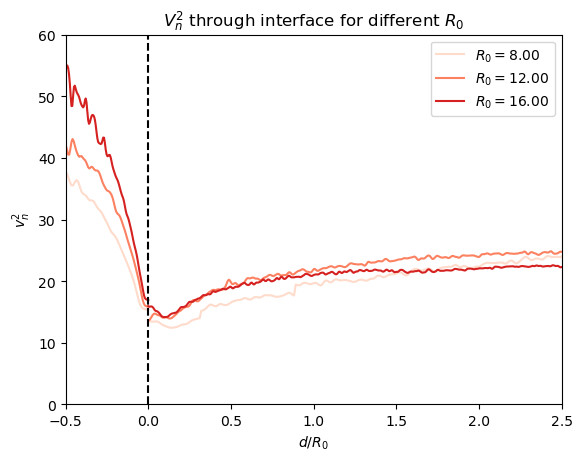

In [26]:


cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
    line, = plt.plot(dist*(-1)/key, vitesseint[key][0,:]**2,color=cmap(i+1),label = f'$R_0 = {key:.2f}$')
    line, = plt.plot(dist2/key, vitesseext[key][0,:]**2,color=cmap(i+1))
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$v_n^2$')
plt.axvline(0,color='k',linestyle='--')
plt.xlim(-0.5,2.5)
plt.ylim(0,60)

plt.title('$V_n^2$ through interface for different $R_0$')
plt.savefig(folderfig + 'vn**2_mean_R0.pdf',bbox_inches='tight')

/tmp/ipykernel_46232/2100389677.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


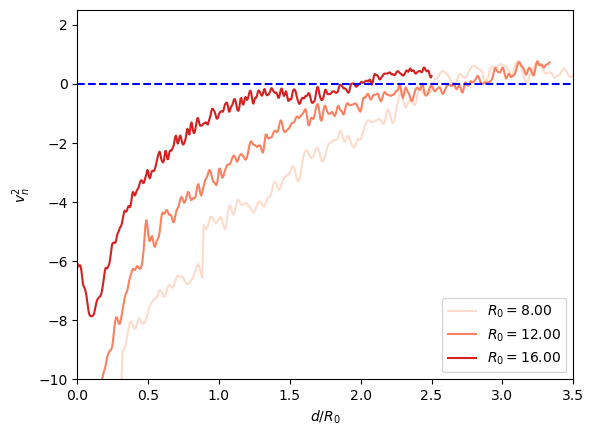

In [74]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
    if key==8.:
        moy = np.sum(vitesseext[key][0,200:375]**2)/len(dist2[200:375])
    else:
        moy = np.sum(vitesseext[key][0,-200:]**2)/len(dist2[-200:])
    line, = plt.plot(dist2/key, vitesseext[key][0,:]**2-moy,color=cmap(i+1),label = f'$R_0 = {key:.2f}$')
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$v_n^2$')
plt.ylim(-10,2.5)
plt.xlim(0,3.5)
plt.axhline(0,color='b',linestyle='--')

/tmp/ipykernel_46232/3319200475.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


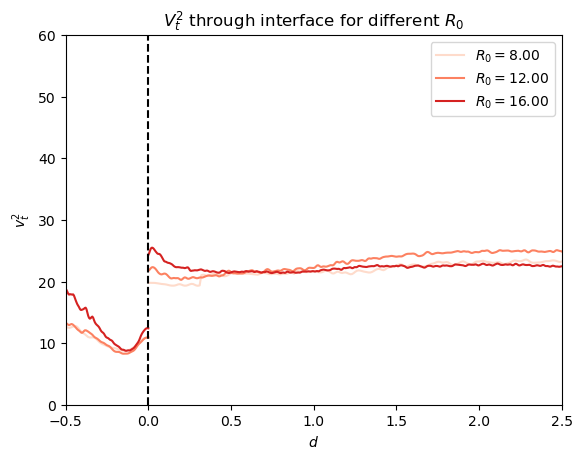

In [31]:

cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
    line, = plt.plot(dist*(-1)/key, (vitesseint[key][1,:]**2+vitesseint[key][2,:]**2)/2,color=cmap(i+1),label = f'$R_0 = {key:.2f}$')
    line, = plt.plot(dist2/key, (vitesseext[key][1,:]**2+vitesseext[key][2,:]**2)/2,color=cmap(i+1))
    i+=2
plt.legend()
plt.xlabel(r'$d$')
plt.ylabel(r'$v_t^2$')
plt.axvline(0,color='k',linestyle='--')
plt.xlim(-0.5,2.5)
plt.ylim(0,60)
plt.title('$V_t^2$ through interface for different $R_0$')
plt.savefig(folderfig + 'vt**2_mean_R0.pdf',bbox_inches='tight')

/tmp/ipykernel_46232/292275362.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


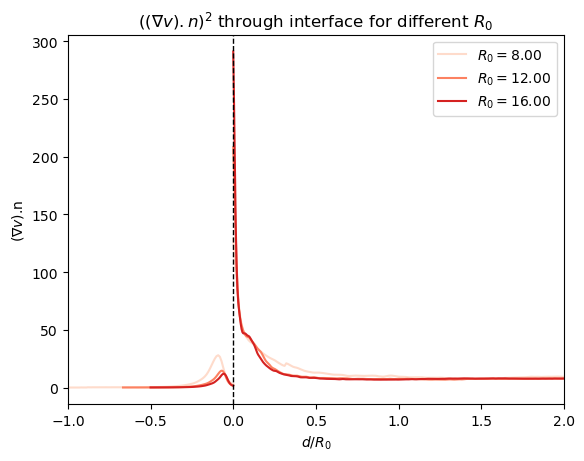

In [33]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
    line, = plt.plot(dist*(-1)/key, vitesseint[key][3,:]**2/25,color=cmap(i+1),label = f'$R_0 = {key:.2f}$')
    line, = plt.plot(dist2/key, vitesseext[key][3,:]**2,color=cmap(i+1))
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'($\nabla v$).n')
plt.xlim(-1,2)
plt.axvline(0,color='k',linestyle='--',lw=1)
plt.title(r'$((\nabla v).n)^2$ through interface for different $R_0$')
plt.savefig(folderfig + 'nablav.n**2_R0.pdf',bbox_inches='tight')

/tmp/ipykernel_46232/2882186187.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)
/tmp/ipykernel_46232/2640741202.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp((-1/a)*x+b)+cte
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '$((\\nabla v).n)^2$ outside for different $R_0$ - zoom')

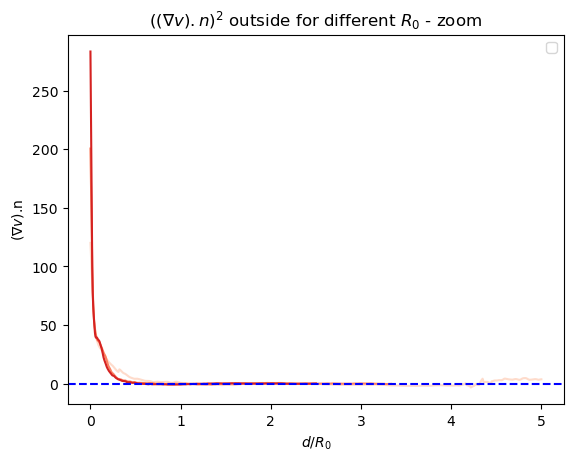

In [57]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
opti = {}
for key in lgammas:
    if key<700:
        pass
    moy = np.sum(vitesseext[key][3,200:]**2)/len(dist2[200:])
    line, = plt.plot(dist2/key, vitesseext[key][3,:]**2-moy,color=cmap(i+1))
    popt,cov = curve_fit(expo_decr,dist2/key,vitesseext[key][3,:]**2)
    if key not in opti:
        opti[key] = popt
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'($\nabla v$).n')
plt.axhline(0,color='b',linestyle = '--')
# plt.ylim(-5,5)
# plt.xlim(0,2.5)
plt.title(r'$((\nabla v).n)^2$ outside for different $R_0$ - zoom')
# plt.savefig( folderfig + 'gradvn**2_out_zoom.pdf', bbox_inches = 'tight')

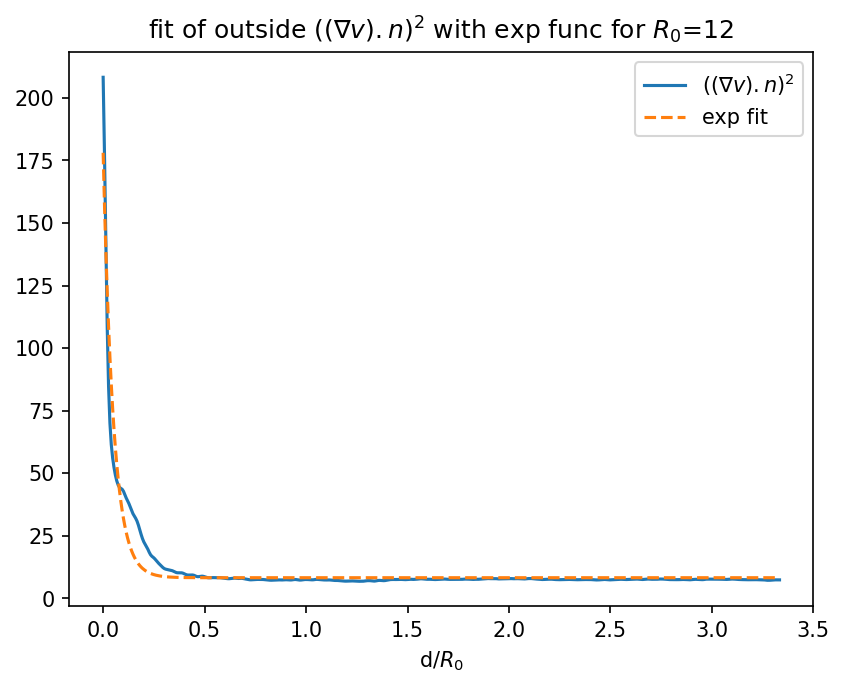

In [64]:
plt.figure(dpi=150)
gam = 12
plt.plot(dist2/gam, vitesseext[gam][3,:]**2,label=r'$((\nabla v).n)^2$')
plt.plot(dist2/gam , expo_decr(dist2/gam, opti[gam][0], opti[gam][1], opti[gam][2]), linestyle = '--', label='exp fit')
plt.legend()
plt.xlabel('d/$R_0$')
plt.title(r'fit of outside $((\nabla v).n)^2$ with exp func for $R_0$=12')
plt.savefig(folderfig + 'expfit_gradvn**2_out_R0=12_')

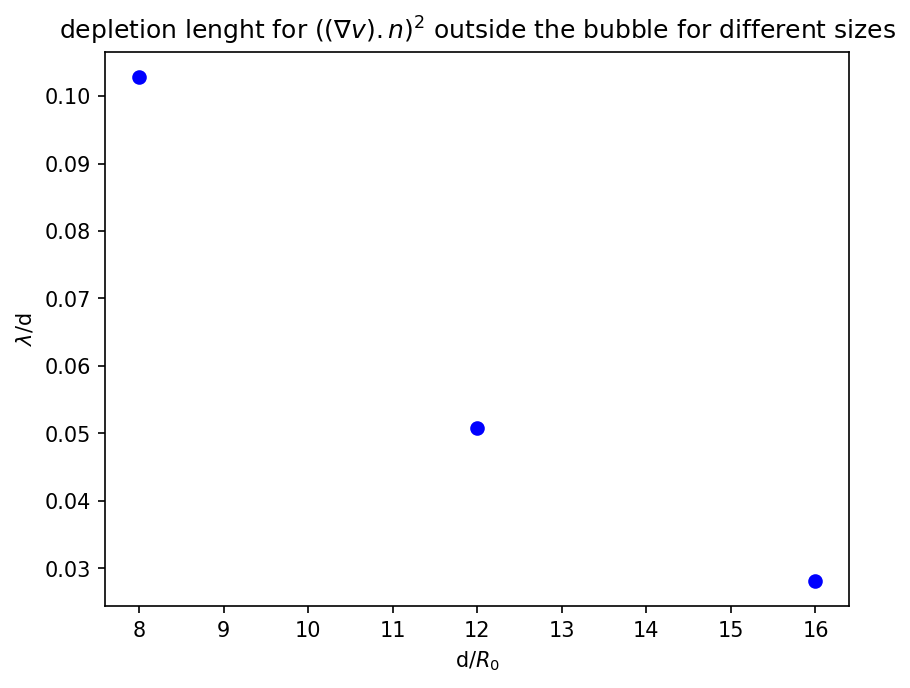

In [78]:
plt.figure(dpi=150)
for key in lgammas:
    plt.scatter(key,opti[key][0],color='b')
plt.xlabel('d/$R_0$')
plt.ylabel(r'$\lambda$/d')
plt.title(r'depletion lenght for $((\nabla v).n)^2$ outside the bubble for different sizes')
plt.savefig( folderfig + 'dpeletion_lenght_gradvn**2_out_R0.pdf', bbox_inches = 'tight')

/tmp/ipykernel_46232/2657553995.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


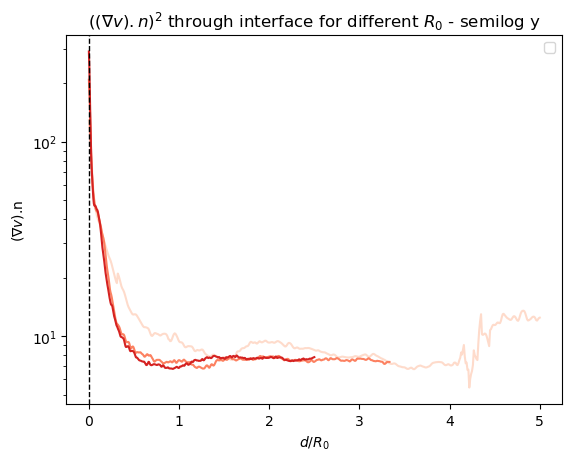

In [34]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
#     line, = plt.plot(dist*(-1)/key, vitesseint[key][3,:]**2/25,color=cmap(i+1),label = f'$R_0 = {key:.2f}$')
    line, = plt.plot(dist2/key, vitesseext[key][3,:]**2,color=cmap(i+1))
    i+=2
plt.legend()
plt.yscale('log')
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'($\nabla v$).n')
# plt.xlim(-1,1)
plt.axvline(0,color='k',linestyle='--',lw=1)
plt.title(r'$((\nabla v).n)^2$ through interface for different $R_0$ - semilog y')
plt.savefig(folderfig + 'nablav.n**2_logy_R0.pdf',bbox_inches='tight')

/tmp/ipykernel_46232/2017833422.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


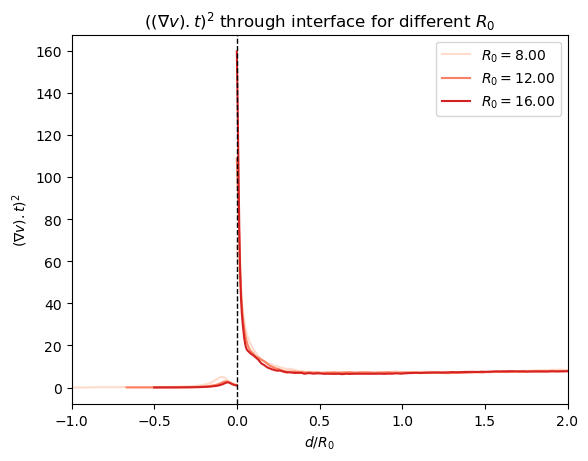

In [36]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
    line, = plt.plot(dist*(-1)/key, (vitesseint[key][4,:]**2+vitesseint[key][5,:]**2)/2/25,color=cmap(i+1),label = f'$R_0 = {key:.2f}$')
    line, = plt.plot(dist2/key, (vitesseext[key][4,:]**2+vitesseext[key][5,:]**2)/2,color=cmap(i+1))
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'($\nabla v).t)^2$')
plt.xlim(-1,2)
plt.title(r'$((\nabla v).t)^2$ through interface for different $R_0$')
plt.axvline(0,color='k',linestyle='--',lw=1)
plt.savefig(folderfig + 'nablav.t**2_R0.pdf',bbox_inches='tight')